In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Don't forget to use `ml_env` environment
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector


In [2]:
pd.set_option('display.max_columns', 50)

def clear_cols(s):
    return s.strip().replace(" ","_")

In [3]:
inpatient_path   = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Inpatientdata-1542865627584.csv'
outpatient_path  = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Outpatientdata-1542865627584.csv'
train_path       = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train-1542865627584.csv'
beneficiary_path = 'MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis/Train_Beneficiarydata-1542865627584.csv'
# path = '/GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis'
# /GitHub Projects/MyProject/MyCapstone/Healthcare Provider Fraud Detection Analysis
# read inpatient outpatient and train files data
inpatient  = pd.read_csv(inpatient_path).rename(columns=clear_cols)
outpatient = pd.read_csv(outpatient_path).rename(columns=clear_cols)
train      = pd.read_csv(train_path).rename(columns=clear_cols)
bene       = pd.read_csv(beneficiary_path).rename(columns=clear_cols)

In [4]:
train.sample()

,Provider,PotentialFraud
328,PRV51419,No


In [5]:
inpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
35300,BENE140754,CLM45492,2009-04-04,2009-04-11,PRV56416,10000,PHY354189,PHY418030,NaN,2009-04-04,4280,1068.0,2009-04-11,228,4280,40390,2761,7245,42833,30000,486,2930,41400,V4975,9904.0,NaN,NaN,NaN,NaN,NaN


In [6]:
inpatient['Provider'].nunique()

2092

In [7]:
df = inpatient.groupby('Provider').agg(
    IPClmAdmitDiagnosisCode = ('ClmAdmitDiagnosisCode', 'nunique')
).reset_index().sort_values(by='IPClmAdmitDiagnosisCode', ascending=False)
df

,Provider,IPClmAdmitDiagnosisCode
388,PRV52019,226
1408,PRV55462,181
896,PRV53706,163
1066,PRV54367,157
1355,PRV55209,151
...,...,...
1748,PRV56603,1
1747,PRV56601,1
286,PRV51626,1
1473,PRV55699,1


In [8]:
outpatient.sample()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,DeductibleAmtPaid,ClmAdmitDiagnosisCode
37677,BENE21743,CLM682191,2009-11-15,2009-11-15,PRV52648,90,PHY337422,NaN,NaN,5845,75310,4019,7812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN


In [9]:
outpatient['Provider'].nunique()

5012

In [10]:
out_df = outpatient.groupby('Provider').agg(
    OPClmAdmitDiagnosisCode = ('ClmAdmitDiagnosisCode', 'nunique')
).reset_index().sort_values(by='OPClmAdmitDiagnosisCode', ascending=False)
out_df

,Provider,OPClmAdmitDiagnosisCode
339,PRV51459,582
2105,PRV53797,401
431,PRV51574,399
2186,PRV53918,359
2911,PRV54895,357
...,...,...
4344,PRV56843,0
563,PRV51738,0
1533,PRV53049,0
2213,PRV53949,0


In [11]:
out_df.loc[out_df['OPClmAdmitDiagnosisCode'] == 0]


,Provider,OPClmAdmitDiagnosisCode
4651,PRV57291,0
2602,PRV54450,0
2892,PRV54869,0
4990,PRV57738,0
4962,PRV57707,0
...,...,...
4344,PRV56843,0
563,PRV51738,0
1533,PRV53049,0
2213,PRV53949,0


In [12]:
# Merge IP and OP provider totals
provider_claims = pd.merge(
    df,  # Left: Provider, IP_Claims_Total
    out_df,  # Right: Provider, OP_Claims_Total
    on='Provider',
    how='outer'
).fillna(0)  # Fill NaN with 0 for providers with only one type of claims

In [13]:
provider_claims

,Provider,IPClmAdmitDiagnosisCode,OPClmAdmitDiagnosisCode
0,PRV51001,5.0,6.0
1,PRV51003,46.0,15.0
2,PRV51004,0.0,25.0
3,PRV51005,0.0,158.0
4,PRV51007,3.0,14.0
...,...,...,...
5405,PRV57759,0.0,3.0
5406,PRV57760,0.0,7.0
5407,PRV57761,0.0,16.0
5408,PRV57762,0.0,1.0


In [14]:
provider_claims['IPClmAdmitDiagnosisCode'].sum()

np.float64(31709.0)

In [15]:
provider_claims['OPClmAdmitDiagnosisCode'].sum()

np.float64(83111.0)

In [16]:
# Then merge with fraud labels
final_df = pd.merge(
    provider_claims,
    train[['Provider', 'PotentialFraud']],
    on='Provider',
    how='outer'
)

In [17]:
final_df

,Provider,IPClmAdmitDiagnosisCode,OPClmAdmitDiagnosisCode,PotentialFraud
0,PRV51001,5.0,6.0,No
1,PRV51003,46.0,15.0,Yes
2,PRV51004,0.0,25.0,No
3,PRV51005,0.0,158.0,Yes
4,PRV51007,3.0,14.0,No
...,...,...,...,...
5405,PRV57759,0.0,3.0,No
5406,PRV57760,0.0,7.0,No
5407,PRV57761,0.0,16.0,No
5408,PRV57762,0.0,1.0,No


In [18]:
final_df['PotentialFraud'] = final_df['PotentialFraud'].map({'Yes': 1, 'No': 0})
final_df

,Provider,IPClmAdmitDiagnosisCode,OPClmAdmitDiagnosisCode,PotentialFraud
0,PRV51001,5.0,6.0,0
1,PRV51003,46.0,15.0,1
2,PRV51004,0.0,25.0,0
3,PRV51005,0.0,158.0,1
4,PRV51007,3.0,14.0,0
...,...,...,...,...
5405,PRV57759,0.0,3.0,0
5406,PRV57760,0.0,7.0,0
5407,PRV57761,0.0,16.0,0
5408,PRV57762,0.0,1.0,0


In [19]:
X = final_df[['IPClmAdmitDiagnosisCode', 'OPClmAdmitDiagnosisCode']]

In [20]:
y = final_df['PotentialFraud']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)


In [22]:
# 2. Scale the features (standardization: mean = 0, std = 1).
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit on train, then transform
X_test = scaler.transform(X_test)  # Transform test data using train's mean & std


In [23]:
# 3. Train a logistic regression model.
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)  # Fit model on training data

LogisticRegression(random_state=42)

In [24]:
# 4. Make predictions on the test set.
y_predict = model.predict(X_test)  # Outputs predicted class labels (0 or 1)

y_proba = model.predict_proba(X_test)[:, 1] # predict probabilities between the 0 and 1 (good for the threshold later)


In [25]:
from sklearn.metrics import confusion_matrix
# Assuming y_test contains true labels and y_predict contains predicted labels
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[964  13]
 [ 65  40]]


In [26]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_predict) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.93
Precision: 0.75
Recall: 0.38
F1 Score: 0.51


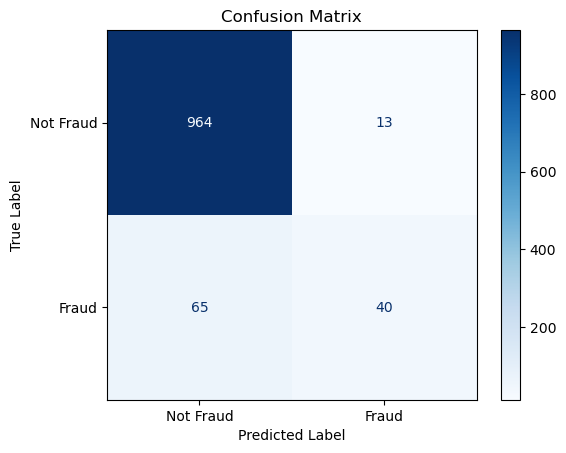

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
# Compute and display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

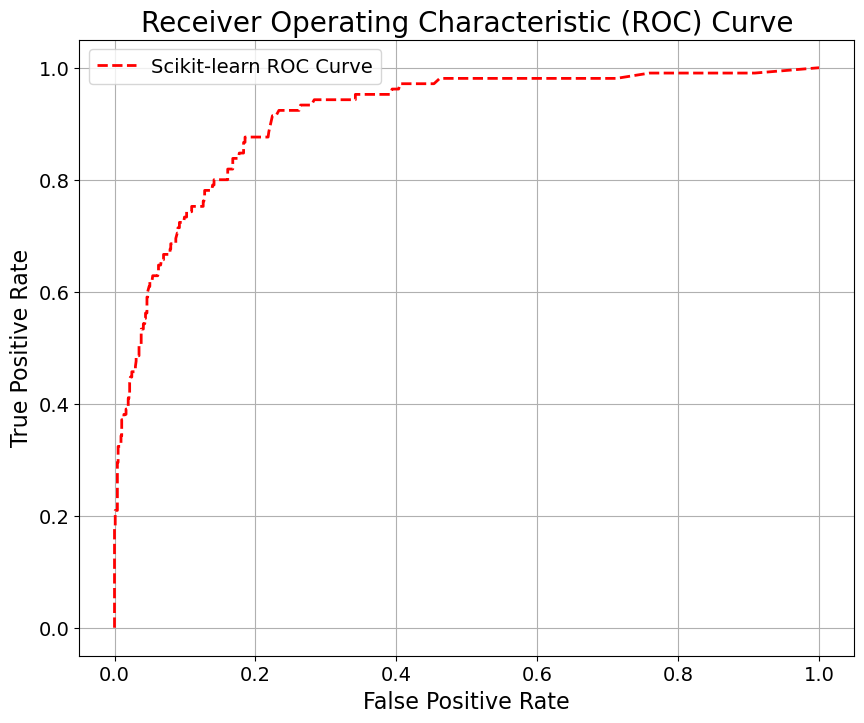

In [28]:
from sklearn.metrics import roc_curve

# Compare with scikit-learn's implementation
# Set up the figure first
fig, ax = plt.subplots(figsize=(10, 8))
# Compare with scikit-learn's implementation
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, 'r--', lw=2, label=f'Scikit-learn ROC Curve') #(AUC = {roc_auc:.2f})')
# Add styling with larger fonts
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=20)
ax.set_xlabel('False Positive Rate', fontsize=16)
ax.set_ylabel('True Positive Rate', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=14)
ax.grid(True)

In [29]:
from sklearn.metrics import auc
# Area Under Curve
auc(fpr, tpr)

np.float64(0.9133255349222594)

### loooking for a better threshold to find better f1 score:

In [29]:
# Get predicted probabilities
y_proba = model.predict_proba(X_test)[:, 1]

In [30]:
precicions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precicions * recalls) / (precicions + recalls)
best_threshold = thresholds[f1_scores.argmax()]
print(f"Optimal threshold based on F1-score: {best_threshold}")

Optimal threshold based on F1-score: 0.1479629377504423


In [31]:
# apply the new best threshold to the predicted probabilities
y_pred_custom = (y_proba >= best_threshold).astype(int)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_custom)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[928  49]
 [ 40  65]]


In [32]:
# flatten the confusion matrix and break it down into four components.
TN, FP, FN, TP = cm.ravel()
# print('Confusion Matrix before manipulating by adding the threshold:\n')

# Calculating metrics
accuracy = accuracy_score(y_test, y_pred_custom) # 2 ways to calculate accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN) # Proportion of correct predictions
print(f'Accuracy: {accuracy:.2f}')
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
print(f'Precision: {precision:.2f}')
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
print(f'Recall: {recall:.2f}')
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.92
Precision: 0.57
Recall: 0.62
F1 Score: 0.59
